# Imports

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt

# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

# Pre-Planning:

#### 1.) Basic MVP notebook.

#### 2.) Run through the entire DS pipeline similar to time series exercise.

#### 3.) initial hypothesis: Has the average temperatures for Greenland increased over time.


-----

# Dataset Info:

- Date: starts in 1750 for average land temperature and 1850 for max and min land temperatures and global ocean and land temperatures
- LandAverageTemperature: global average land temperature in celsius
- LandAverageTemperatureUncertainty: the 95% confidence interval around the average
- LandMaxTemperature: global average maximum land temperature in celsius
- LandMaxTemperatureUncertainty: the 95% confidence interval around the maximum land temperature
- LandMinTemperature: global average minimum land temperature in celsius
- LandMinTemperatureUncertainty: the 95% confidence interval around the minimum land temperature
- LandAndOceanAverageTemperature: global average land and ocean temperature in celsius
- LandAndOceanAverageTemperatureUncertainty: the 95% confidence interval around the global average land and ocean temperature

------

# Wrangle:

In [2]:
#importing csv and creating a DataFrame.
df = pd.read_csv('GlobalLandTemperaturesByCountry.csv')

In [3]:
df.head(100)

,dt,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
95,1751-10-01,NaN,NaN,Åland
96,1751-11-01,NaN,NaN,Åland
97,1751-12-01,NaN,NaN,Åland
98,1752-01-01,-4.633,2.852,Åland


In [4]:
#will focus on greenland
df = df[df.Country == 'Greenland']


In [5]:
#shape of df is 2289 records x 3 fields
df.shape

(2289, 4)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2289 entries, 209895 to 212183
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2289 non-null   object 
 1   AverageTemperature             2288 non-null   float64
 2   AverageTemperatureUncertainty  2288 non-null   float64
 3   Country                        2289 non-null   object 
dtypes: float64(2), object(2)
memory usage: 89.4+ KB


In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AverageTemperature,2288.0,-18.587458,10.850606,-37.658,-28.56125,-21.2645,-6.69425,0.339
AverageTemperatureUncertainty,2288.0,1.822842,1.032897,0.358,0.93600,1.5925,2.80925,8.425


In [8]:
#looking into percentage of nans
df.isna().sum()/len(df)

dt                               0.000000
AverageTemperature               0.000437
AverageTemperatureUncertainty    0.000437
Country                          0.000000
dtype: float64

### Main Takeaways:
- 1.) Need to change temperature to Farenheight.
- 2.) rename dt to date, 
- 3.) will focus on Greenland.
- 4.) Alot of the temperatures in greenland are negative.

 -------

# Prepare:

### Goals:

- 1.) Convert Temp to Faren from celsius. Rename to shorter.
- 2.) Temperatures need to be rounded to two decimal places(hundreth).
- 3.) Can remove the Country Column, know I am working just with greenland.
- 4.) change date to datetime from object.
- 5.) Set index to date and sort.
- 6.) Feel comfortable dropping Nans.
- 7.) Find outliers and figure out what to do with them.


In [9]:
df.columns

Index(['dt', 'AverageTemperature', 'AverageTemperatureUncertainty', 'Country'], dtype='object')

In [10]:
#renaming temp to shorten column names
df.rename(columns = {'dt': 'date', 'AverageTemperature': 'avg_temp', 'AverageTemperatureUncertainty':'avg_temp_uncer' },inplace = True)

In [11]:
#dropping column country since its just greenland.
df.drop(columns = ['Country', 'avg_temp_uncer'],inplace = True)

In [12]:
#converting to faren
df['avg_temp'] = round(df['avg_temp'] * 9/5 + 32,2)

In [13]:
df.head(10)

,date,avg_temp
209895,1823-01-01,-21.86
209896,1823-02-01,-26.27
209897,1823-03-01,-20.32
209898,1823-04-01,-7.66
209899,1823-05-01,7.86
209900,1823-06-01,24.87
209901,1823-07-01,29.90
209902,1823-08-01,23.32
209903,1823-09-01,9.03
209904,1823-10-01,-7.52


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2289 entries, 209895 to 212183
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      2289 non-null   object 
 1   avg_temp  2288 non-null   float64
dtypes: float64(1), object(1)
memory usage: 53.6+ KB


In [15]:
#will just drop nulls
df.dropna(inplace = True)

In [16]:
#new shape 2288 records x 3 columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2288 entries, 209895 to 212182
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      2288 non-null   object 
 1   avg_temp  2288 non-null   float64
dtypes: float64(1), object(1)
memory usage: 53.6+ KB


In [17]:
#converting date to datetime type. Removing Leap year
df['date'] = pd.to_datetime(df.date).sort_values()
df = df[~((df.date.dt.month == 2) & (df.date.dt.day == 29))]

In [24]:
# set index
df = df.set_index('date')

In [27]:
df =df.loc['1940-01-01':]

In [28]:
print('Data ranges from {} to {}'.format(df.index.min(), df.index.max()))

Data ranges from 1940-01-01 00:00:00 to 2013-08-01 00:00:00


In [32]:
# aggregate or resample daily by summing Amount
df = df.resample('6M')[['avg_temp']].sum()
# remove leap day


In [33]:
print('Data ranges from {} to {}'.format(df.index.min(), df.index.max()))

Data ranges from 1940-01-31 00:00:00 to 2014-01-31 00:00:00


<AxesSubplot:xlabel='date'>

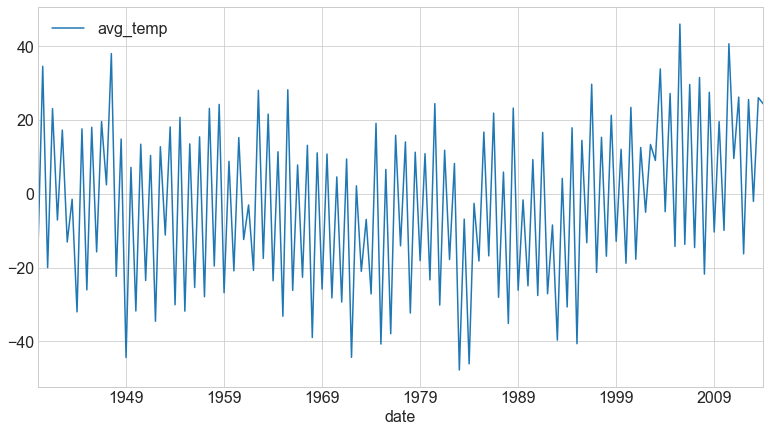

In [34]:
df.plot()

## Splitting the Data

In [35]:
# train will be half the df
train_size = int(len(df) * 0.5)
train_size 

74

In [36]:
# set validate size to be 30% of total 
validate_size = int(len(df) * 0.3)
validate_size

44

In [37]:
# set test size to be number of rows remaining. 
test_size = int(len(df) - train_size - validate_size)
test_size

31

In [38]:
#specifying the validate end point, have to do this to specifiy number at which validate ends so can specify test.
validate_end_index = train_size + validate_size
validate_end_index

118

In [39]:
# train will go from 0 to 95
train = df[:train_size]
# validate will go from 96 to 153
validate = df[train_size:validate_end_index]
# test will include 154 to end
test = df[validate_end_index:]

## Split Verification:

In [40]:
# is len of train + validate + test == lenght of entire dataframe. 
print(len(train) + len(validate) + len(test) == len(df))

True


In [41]:
# is record for beginning of df same as train.
print(df.head(1) == train.head(1))

            avg_temp
date                
1940-01-31      True


In [42]:
#Train end and validate start are different
pd.concat([train.tail(1), validate.head(1)])

,avg_temp
date,
1976-07-31,15.88
1977-01-31,-14.07


In [43]:
# validate end and test start different
pd.concat([validate.tail(1), test.head(1)])

,avg_temp
date,
1998-07-31,21.28
1999-01-31,-12.86


In [44]:
#end of test and df the same, yes
pd.concat([test.tail(1), df.tail(1)])

,avg_temp
date,
2014-01-31,24.4
2014-01-31,24.4


In [45]:
# so split was successful!

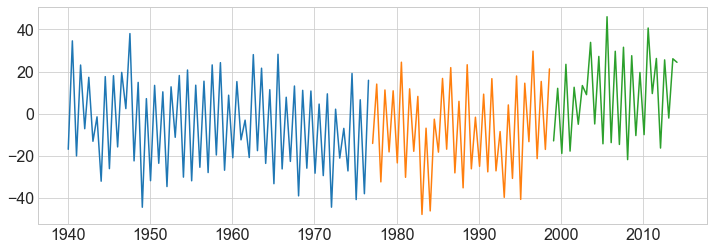

In [46]:
#plotting train validate, test.
plt.figure(figsize=(12,4))
plt.plot(train)
plt.plot(validate)
plt.plot(test)

### Main Takeaways:

#### - 1.) Dropped NANs and  the columns Country and temp uncer. Know this is Greenland and temp uncer wont be utilized.
#### - 2.) Sorted Date and set the index to date.
#### - 3.) Resampled(GROUP BY) Year and sum the avg temp for the year.
#### - 4.) Split the data into a train, validate and test set.



-----

# Explore:

## Goal:

- ### Look for trends in temp over time. 

In [48]:
y = train.avg_temp

### Distribution of target: univariate exploration

<AxesSubplot:ylabel='Frequency'>

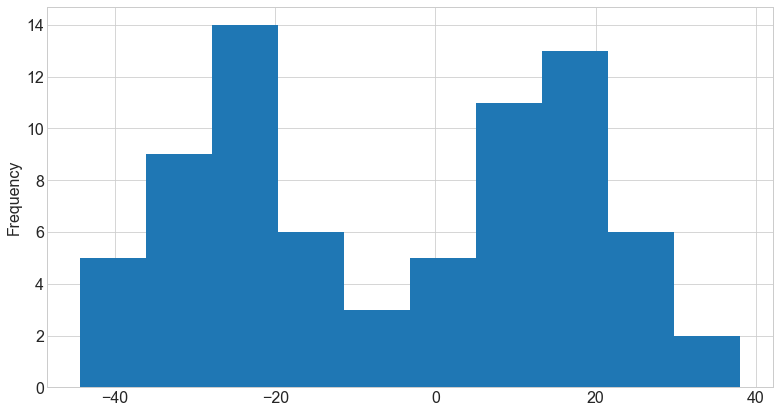

In [49]:
y.plot.hist()

[Text(0.5, 1.0, 'Sum Avg temp by Year'),
 Text(0.5, 0, 'year'),
 Text(0, 0.5, 'avg_temp')]

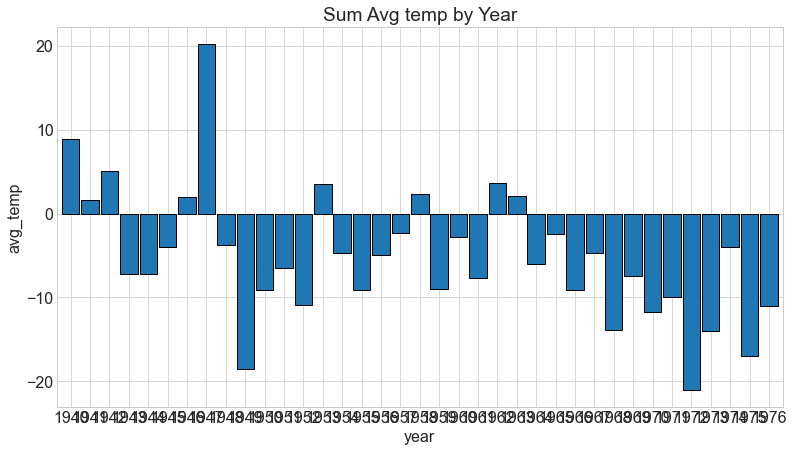

In [50]:
ax = y.groupby(y.index.year).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0,)
ax.set(title='Sum Avg temp by 6Months', xlabel='year', ylabel='avg_temp')

## Auto_Correlation 

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

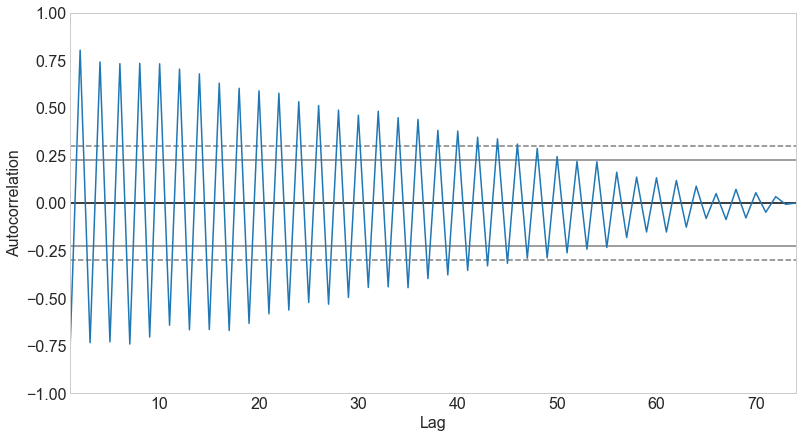

In [51]:
pd.plotting.autocorrelation_plot(train.avg_temp)

## Decomposition

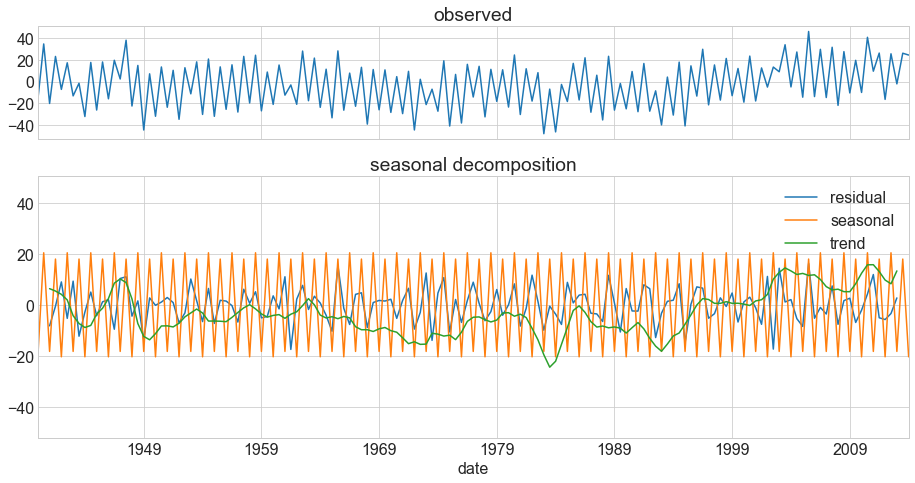

In [52]:
result = sm.tsa.seasonal_decompose(df, model='additive')
result = pd.DataFrame(dict(
    observed=result.observed,
    residual=result.resid,
    seasonal=result.seasonal,
    trend=result.trend
))
gs = plt.GridSpec(3, 1)
fig = plt.figure()
ax1 = fig.add_subplot(gs[1:])
ax2 = fig.add_subplot(gs[0], sharex=ax1, sharey=ax1)
result.iloc[:, 1:].loc['1940':].plot(ax=ax1, title='seasonal decomposition')
result.observed.loc['1940':].plot(ax=ax2, title='observed')
fig.tight_layout()

<AxesSubplot:xlabel='date'>

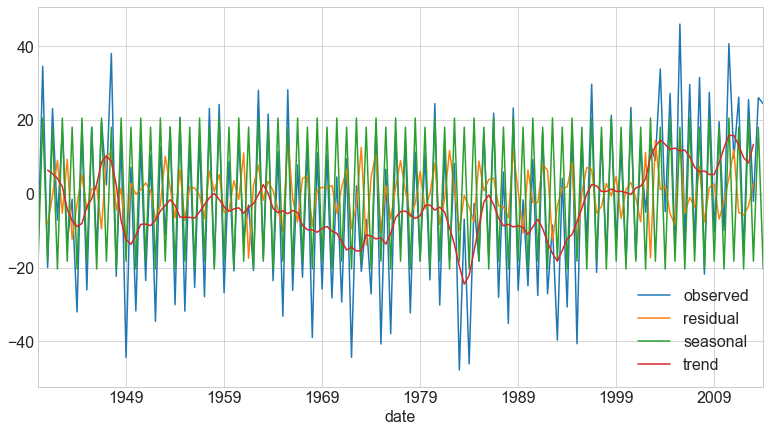

In [53]:
result.plot()

## Categories over time

In [54]:
train['temp_bin'] = pd.qcut(train.avg_temp, 4, labels=['cold', 'cool', 'warmer', 'hot'])
train.groupby('temp_bin').mean()

,avg_temp
temp_bin,
cold,-32.456316
cool,-17.786111
warmer,7.848889
hot,21.735789


Text(0, 0.5, '% of months in the year')

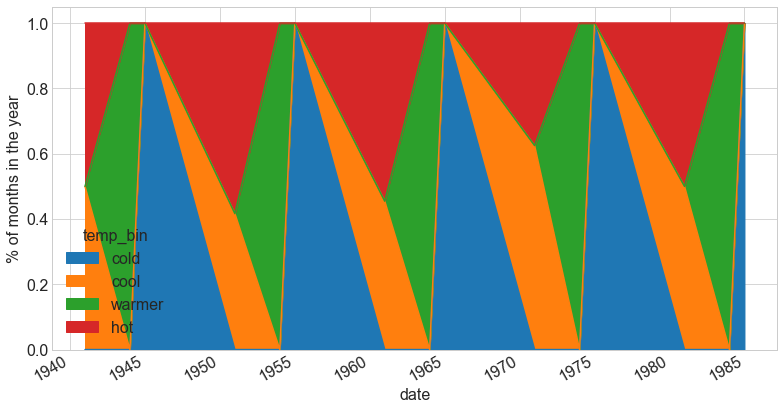

In [55]:
(train.groupby('temp_bin')
 .resample('10Y')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of months in the year')

---------

# Forecasting

## Forecast 

Forecasting is another word for predicting time series data. 

1. Last Observed Value: The future will look like the now
2. Simple Average: The future will look, on average, like history. 
3. Moving Average: The future will look, on average, like recent history. 
4. Holt's Linear Trend
5. Previous Cycle


### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

**Make Predictions**

Avg_temp

In [58]:
# take the last item of avg_temp and assign to variable
temp = round(train['avg_temp'][-1:][0], 2)
temp

15.88

In [59]:
yhat_df = pd.DataFrame({'avg_temp': [temp]}, 
                      index = validate.index)

yhat_df.head()

,avg_temp
date,
1977-01-31,15.88
1977-07-31,15.88
1978-01-31,15.88
1978-07-31,15.88
1979-01-31,15.88


In [60]:
yhat_df.describe()

,avg_temp
count,4.400000e+01
mean,1.588000e+01
std,3.593787e-15
min,1.588000e+01
25%,1.588000e+01
50%,1.588000e+01
75%,1.588000e+01
max,1.588000e+01
